------------------------------------------------ 데이터 로딩 ------------------------------------------------ 

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import time
import datetime

train = pd.read_csv('/Users/jaesolshin/내 드라이브/2024-2/Google ML Bootcamp2024/data/playground1/train.csv')

In [2]:
# 시작 시간 기록
full_start_time = time.time()

In [3]:
# 전체 데이터의 인덱스 생성
indices = np.arange(train.shape[0])

# 99:1 비율로 train, valid 분할
train_id, valid_id = train_test_split(indices, test_size=0.01, random_state=42)

# train에서 sample_t개, valid에서 sample_v개 샘플링
sample_t = 30000
sample_v = 1000
train_sample_id = np.random.choice(train_id, sample_t, replace=False)
valid_sample_id = np.random.choice(valid_id, sample_v, replace=False)

# train_x, train_y, valid_x, valid_y 생성
train_x = train.iloc[train_sample_id, :-1]
train_y = train.iloc[train_sample_id, -1]
valid_x = train.iloc[valid_sample_id, :-1]
valid_y = train.iloc[valid_sample_id, -1]

print("Train sample X shape:", train_x.shape)
print("Train sample Y shape:", train_y.shape)
print("Valid sample X shape:", valid_x.shape)
print("Valid sample Y shape:", valid_y.shape)

Train sample X shape: (30000, 11)
Train sample Y shape: (30000,)
Valid sample X shape: (1000, 11)
Valid sample Y shape: (1000,)


------------------------------------------------ 여기서부터 데이터 확인 및 전처리 ------------------------------------------------

In [4]:
train_x.head()
train_x.describe(include='all')
train_x['Driving_License'].value_counts() #면허 미소지자도 드물게 존재
train_y.value_counts()

Response
0    26262
1     3738
Name: count, dtype: int64

In [5]:
# 범주형 변수들만 따로 확인
train_x.iloc[:10,[1,3,4,5,6,7,9]] 

# 범주형 변수를 팩터로 변환 (카테고리형)
train_x.iloc[:,[1,3,4,5,6,7,9]].apply(lambda x: x.astype('category'))
valid_x.iloc[:,[1,3,4,5,6,7,9]].apply(lambda x: x.astype('category'))

# 결측치 파악
print(train_x.isnull().sum()) #결측 없음
print(valid_x.isnull().sum()) #결측 없음

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
dtype: int64
id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
dtype: int64


Age                  0
Annual_Premium    6212
Vintage              0
dtype: int64


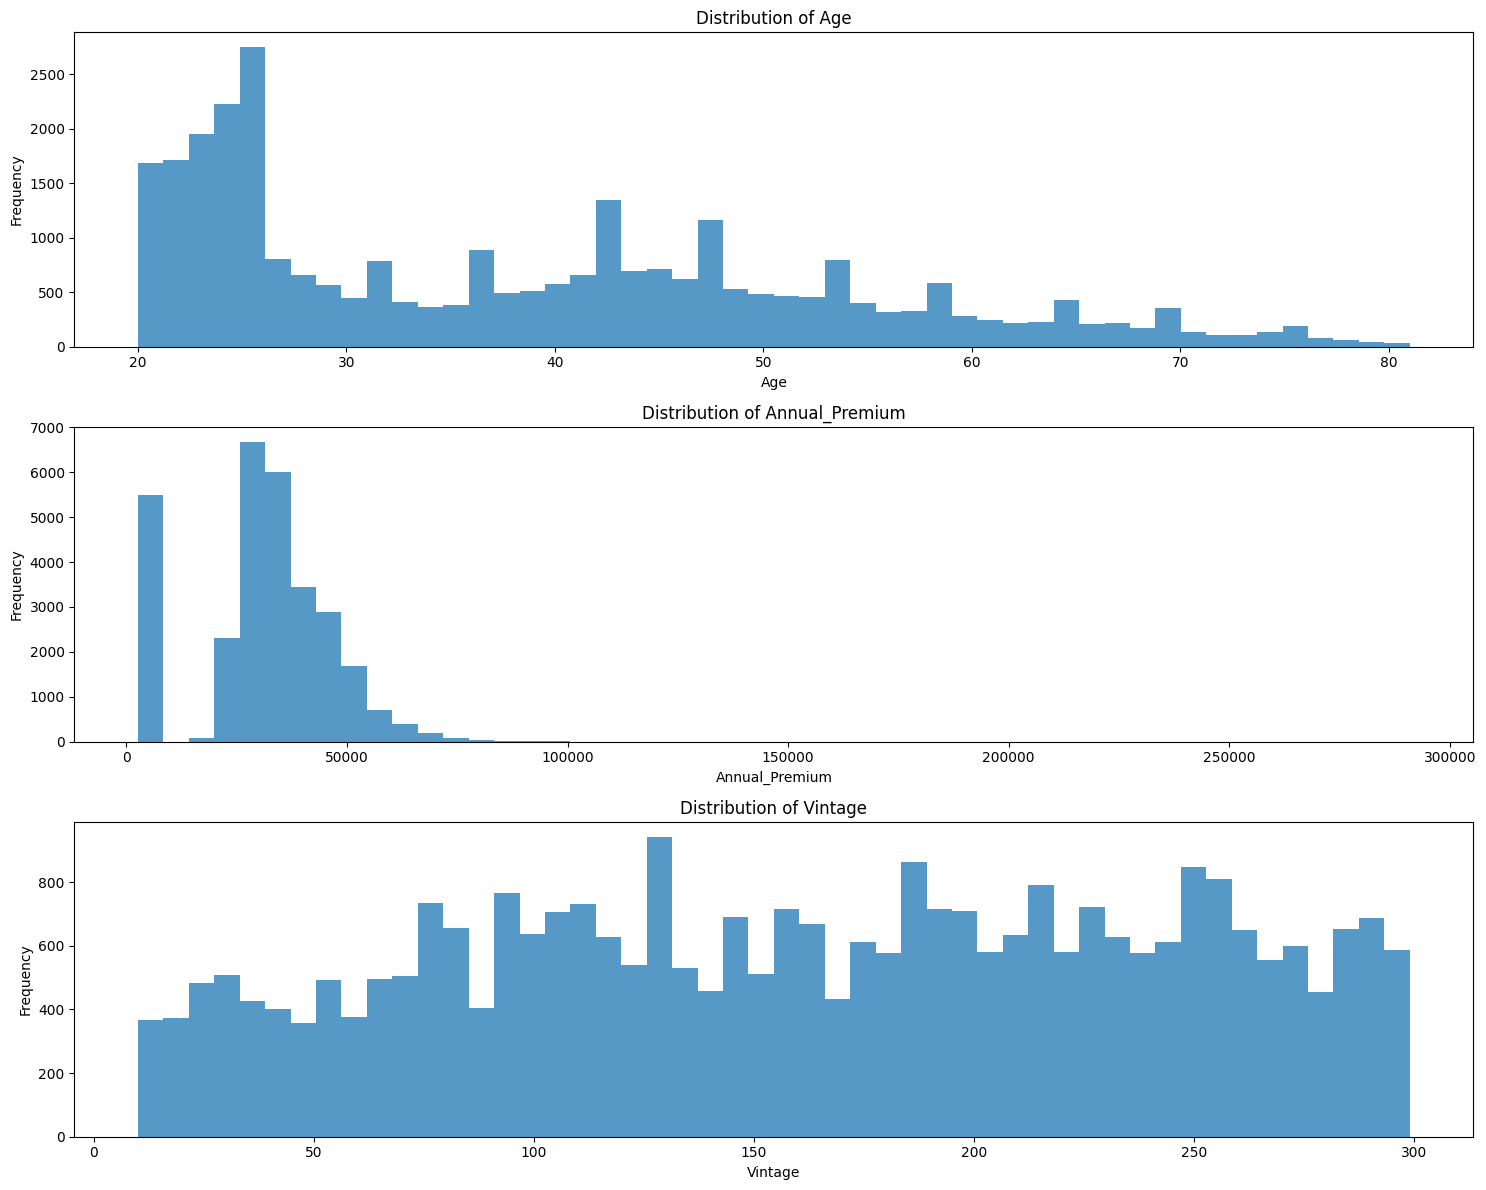

In [6]:
# 연속형 변수만 선택
train_x.iloc[:10,[2,8,10]]

# IQR 기반 이상치 탐지 함수
def outliers(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    outliers = ((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR)))
    return outliers

# 연속형 변수들에 대해 이상치 수 계산
print(outliers(train_x.iloc[:,[2,8,10]]).sum())

#연속형 변수들 시각화
fig, axes = plt.subplots(nrows=3, figsize=(15, 12))
axes = axes.flatten()

# 각 변수의 히스토그램 그리기
for ax, column in zip(axes, train_x.iloc[:,[2,8,10]]):
    ax.hist(train_x[column], bins=50, alpha=0.75)
    ax.set_title(f"Distribution of {column}")
    ax.set_xlabel(column)
    ax.set_ylabel("Frequency")


plt.tight_layout()
plt.show()

#Annual_Premium 변수의 min값이 정규분포에서 크게 튀어보이는 것을 확인할 수 있음


In [7]:
#튀어보이는 수치는 0이 아닌 2630.0
print(train_x["Annual_Premium"].min())
print(train_x["Annual_Premium"].min())

#이상치로 판단된 값 또한 대부분 2630.0
train_x.loc[outliers(train_x["Annual_Premium"]),"Annual_Premium"].value_counts()

# 이분변수 생성: "Annual_Premium" == 2630.0 인 경우
train_x['Annual_Premium_Binary'] = (train_x['Annual_Premium'] == 2630.0).astype('category')
valid_x['Annual_Premium_Binary'] = (valid_x['Annual_Premium'] == 2630.0).astype('category')

# 로그 변환된 "Annual_Premium" 변수 생성
train_x['Annual_Premium_Log'] = np.log1p(train_x['Annual_Premium'])
valid_x['Annual_Premium_Log'] = np.log1p(valid_x['Annual_Premium'])

#생성된 변수 확인
train_x.head()

2630.0
2630.0


,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Annual_Premium_Binary,Annual_Premium_Log
1899000,1899000,Female,25,1,28.0,1,< 1 Year,No,51137.0,152.0,128,False,10.842283
7204923,7204923,Male,68,1,31.0,0,1-2 Year,Yes,2630.0,9.0,103,True,7.875119
8651600,8651600,Female,58,1,46.0,1,1-2 Year,No,2630.0,26.0,43,True,7.875119
1329390,1329390,Male,61,1,1.0,1,1-2 Year,No,2630.0,26.0,98,True,7.875119
10489951,10489951,Male,24,1,3.0,1,< 1 Year,No,25671.0,152.0,171,False,10.153156


In [8]:
# 정규화
# StandardScaler, MinMaxScaler, RobustScaler 중에서 선택
from sklearn.preprocessing import StandardScaler

# 최소-최대 정규화 (Min-Max 스케일링)
scaler = StandardScaler()
train_x.iloc[:,[2,8,10]] = scaler.fit_transform(train_x.iloc[:,[2,8,10]])
valid_x.iloc[:,[2,8,10]] = scaler.fit_transform(valid_x.iloc[:,[2,8,10]])

train_x.head()

/var/folders/fx/7qldcfl92nb_g9hqp_lrssxm0000gn/T/ipykernel_44099/4270348271.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.88999433  1.9781508   1.31114031 ... -0.55648908 -0.95669538
 -1.02339643]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  train_x.iloc[:,[2,8,10]] = scaler.fit_transform(train_x.iloc[:,[2,8,10]])
/var/folders/fx/7qldcfl92nb_g9hqp_lrssxm0000gn/T/ipykernel_44099/4270348271.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.44260711 -0.75672137 -1.51059561 ...  1.30386822  0.13536315
 -0.44260711]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  train_x.iloc[:,[2,8,10]] = scaler.fit_transform(train_x.iloc[:,[2,8,10]])
/var/folders/fx/7qldcfl92nb_g9hqp_lrssxm0000gn/T/ipykernel_44099/4270348271.py:8: FutureWarning: Setting an item o

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Annual_Premium_Binary,Annual_Premium_Log
1899000,1899000,Female,-0.889994,1,28.0,1,< 1 Year,No,1.284762,152.0,-0.442607,False,10.842283
7204923,7204923,Male,1.978151,1,31.0,0,1-2 Year,Yes,-1.718185,9.0,-0.756721,True,7.875119
8651600,8651600,Female,1.311140,1,46.0,1,1-2 Year,No,-1.718185,26.0,-1.510596,True,7.875119
1329390,1329390,Male,1.511243,1,1.0,1,1-2 Year,No,-1.718185,26.0,-0.819544,True,7.875119
10489951,10489951,Male,-0.956695,1,3.0,1,< 1 Year,No,-0.291774,152.0,0.097669,False,10.153156


In [9]:
# 예측에 필요 없는 'id'와 'Annual_Premium' 변수를 드롭
train_x = train_x.drop(columns=['id', 'Annual_Premium'])
valid_x = valid_x.drop(columns=['id', 'Annual_Premium'])

# 원-핫 인코딩 (One-Hot Encoding)
train_x = pd.get_dummies(train_x, columns=['Gender', 'Driving_License', 'Region_Code', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Policy_Sales_Channel', 'Annual_Premium_Binary'])
valid_x = pd.get_dummies(valid_x, columns=['Gender', 'Driving_License', 'Region_Code', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Policy_Sales_Channel', 'Annual_Premium_Binary'])

# train_x와 valid_x가 동일한 열을 가지도록 조정
train_x, valid_x = train_x.align(valid_x, join='left', axis=1, fill_value=0)

#생성된 변수 확인
train_x.head()

,Age,Vintage,Annual_Premium_Log,Gender_Female,Gender_Male,Driving_License_0,Driving_License_1,Region_Code_0.0,Region_Code_1.0,Region_Code_2.0,...,Policy_Sales_Channel_154.0,Policy_Sales_Channel_155.0,Policy_Sales_Channel_156.0,Policy_Sales_Channel_157.0,Policy_Sales_Channel_158.0,Policy_Sales_Channel_159.0,Policy_Sales_Channel_160.0,Policy_Sales_Channel_163.0,Annual_Premium_Binary_False,Annual_Premium_Binary_True
1899000,-0.889994,-0.442607,10.842283,True,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,True,False
7204923,1.978151,-0.756721,7.875119,False,True,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,True
8651600,1.311140,-1.510596,7.875119,True,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,True
1329390,1.511243,-0.819544,7.875119,False,True,False,True,False,True,False,...,False,False,False,False,False,False,False,False,False,True
10489951,-0.956695,0.097669,10.153156,False,True,False,True,False,False,False,...,False,False,False,False,False,False,False,False,True,False


------------------------------------------------ 이제 드디어 모델링 ------------------------------------------------

In [23]:
#평가를 위한 패키지 임포트
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc

In [11]:
from sklearn.linear_model import LogisticRegression

# 시작 시간 기록
start_time = time.time()

# 로지스틱 회귀 모델 생성 및 학습
logistic_model = LogisticRegression(max_iter=1000, random_state=42)
logistic_model.fit(train_x, train_y)

# 검증 데이터에 대해 예측
valid_y_pred = logistic_model.predict(valid_x)

# 성능 평가
accuracy = accuracy_score(valid_y, valid_y_pred)
conf_matrix = confusion_matrix(valid_y, valid_y_pred)
class_report = classification_report(valid_y, valid_y_pred)

# 결과 출력
print(accuracy)
print(conf_matrix)
print(class_report)

# 종료 시간 기록
end_time = time.time()
execution_time = end_time - start_time
print("실행 시간: %f초" %execution_time)

0.871
[[870   1]
 [128   1]]
              precision    recall  f1-score   support

           0       0.87      1.00      0.93       871
           1       0.50      0.01      0.02       129

    accuracy                           0.87      1000
   macro avg       0.69      0.50      0.47      1000
weighted avg       0.82      0.87      0.81      1000

실행 시간: 3.125725초


In [12]:
'''
from sklearn.svm import SVC

# 시작 시간 기록
start_time = time.time()

# SVM 모델 생성 및 학습
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(train_x, train_y)

# 검증 데이터에 대해 예측
valid_y_pred_svm = svm_model.predict(valid_x)

# 성능 평가
accuracy_svm1 = accuracy_score(valid_y, valid_y_pred_svm)
conf_matrix_svm1 = confusion_matrix(valid_y, valid_y_pred_svm)
class_report_svm1 = classification_report(valid_y, valid_y_pred_svm)

# 결과 출력
print(accuracy_svm1)
print(conf_matrix_svm1)
print(class_report_svm1)

# 종료 시간 기록
end_time = time.time()
execution_time = end_time - start_time
print("실행 시간: %f초" %execution_time)
'''

'\nfrom sklearn.svm import SVC\n\n# 시작 시간 기록\nstart_time = time.time()\n\n# SVM 모델 생성 및 학습\nsvm_model = SVC(kernel=\'linear\', random_state=42)\nsvm_model.fit(train_x, train_y)\n\n# 검증 데이터에 대해 예측\nvalid_y_pred_svm = svm_model.predict(valid_x)\n\n# 성능 평가\naccuracy_svm1 = accuracy_score(valid_y, valid_y_pred_svm)\nconf_matrix_svm1 = confusion_matrix(valid_y, valid_y_pred_svm)\nclass_report_svm1 = classification_report(valid_y, valid_y_pred_svm)\n\n# 결과 출력\nprint(accuracy_svm1)\nprint(conf_matrix_svm1)\nprint(class_report_svm1)\n\n# 종료 시간 기록\nend_time = time.time()\nexecution_time = end_time - start_time\nprint("실행 시간: %f초" %execution_time)\n'

In [13]:
'''
# 시작 시간 기록
start_time = time.time()

# SVM 모델 생성 및 학습
svm_model = SVC(kernel='rbf', random_state=42)
svm_model.fit(train_x, train_y)

# 검증 데이터에 대해 예측
valid_y_pred_svm = svm_model.predict(valid_x)

# 성능 평가
accuracy_svm2 = accuracy_score(valid_y, valid_y_pred_svm)
conf_matrix_svm2 = confusion_matrix(valid_y, valid_y_pred_svm)
class_report_svm2 = classification_report(valid_y, valid_y_pred_svm)

# 결과 출력
print(accuracy_svm2)
print(conf_matrix_svm2)
print(class_report_svm2)

# 종료 시간 기록
end_time = time.time()
execution_time = end_time - start_time
print("실행 시간: %f초" %execution_time)
'''

'\n# 시작 시간 기록\nstart_time = time.time()\n\n# SVM 모델 생성 및 학습\nsvm_model = SVC(kernel=\'rbf\', random_state=42)\nsvm_model.fit(train_x, train_y)\n\n# 검증 데이터에 대해 예측\nvalid_y_pred_svm = svm_model.predict(valid_x)\n\n# 성능 평가\naccuracy_svm2 = accuracy_score(valid_y, valid_y_pred_svm)\nconf_matrix_svm2 = confusion_matrix(valid_y, valid_y_pred_svm)\nclass_report_svm2 = classification_report(valid_y, valid_y_pred_svm)\n\n# 결과 출력\nprint(accuracy_svm2)\nprint(conf_matrix_svm2)\nprint(class_report_svm2)\n\n# 종료 시간 기록\nend_time = time.time()\nexecution_time = end_time - start_time\nprint("실행 시간: %f초" %execution_time)\n'

In [14]:
from sklearn.ensemble import RandomForestClassifier

# 시작 시간 기록
start_time = time.time()

# Random Forest 모델 생성 및 학습
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(train_x, train_y)

# 검증 데이터에 대해 예측
valid_y_pred_rf = rf_model.predict(valid_x)

# 성능 평가
accuracy_rf = accuracy_score(valid_y, valid_y_pred_rf)
conf_matrix_rf = confusion_matrix(valid_y, valid_y_pred_rf)
class_report_rf = classification_report(valid_y, valid_y_pred_rf)

# 결과 출력
print(accuracy_rf)
print(conf_matrix_rf)
print(class_report_rf)

# 종료 시간 기록
end_time = time.time()
execution_time = end_time - start_time
print("실행 시간: %f초" %execution_time)

0.869
[[846  25]
 [106  23]]
              precision    recall  f1-score   support

           0       0.89      0.97      0.93       871
           1       0.48      0.18      0.26       129

    accuracy                           0.87      1000
   macro avg       0.68      0.57      0.59      1000
weighted avg       0.84      0.87      0.84      1000

실행 시간: 12.086268초


In [15]:
from catboost import CatBoostClassifier

# 시작 시간 기록
start_time = time.time()

# CatBoost 모델 생성 및 학습
catboost_model = CatBoostClassifier(iterations=100, random_seed=42, silent=True)
catboost_model.fit(train_x, train_y)

# 검증 데이터에 대해 예측
valid_y_pred_catboost = catboost_model.predict(valid_x)

# 성능 평가
accuracy_cat = accuracy_score(valid_y, valid_y_pred_catboost)
conf_matrix_cat = confusion_matrix(valid_y, valid_y_pred_catboost)
class_report_cat = classification_report(valid_y, valid_y_pred_catboost)

# 결과 출력
print(accuracy_cat)
print(conf_matrix_cat)
print(class_report_cat)

# 종료 시간 기록
end_time = time.time()
execution_time = end_time - start_time
print("실행 시간: %f초" %execution_time)

0.868
[[857  14]
 [118  11]]
              precision    recall  f1-score   support

           0       0.88      0.98      0.93       871
           1       0.44      0.09      0.14       129

    accuracy                           0.87      1000
   macro avg       0.66      0.53      0.54      1000
weighted avg       0.82      0.87      0.83      1000

실행 시간: 3.597342초


In [16]:
from lightgbm import LGBMClassifier

# 시작 시간 기록
start_time = time.time()

# LightGBM 모델 생성 및 학습
lgbm_model = LGBMClassifier(n_estimators=100, random_state=42)
lgbm_model.fit(train_x, train_y)

# 검증 데이터에 대해 예측
valid_y_pred_lgbm = lgbm_model.predict(valid_x)

# 성능 평가
accuracy_lgbm = accuracy_score(valid_y, valid_y_pred_lgbm)
conf_matrix_lgbm = confusion_matrix(valid_y, valid_y_pred_lgbm)
class_report_lgbm = classification_report(valid_y, valid_y_pred_lgbm)

# 결과 출력
print(accuracy_lgbm)
print(conf_matrix_lgbm)
print(class_report_lgbm)

# 종료 시간 기록
end_time = time.time()
execution_time = end_time - start_time
print("실행 시간: %f초" %execution_time)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3738, number of negative: 26262
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008402 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 769
[LightGBM] [Info] Number of data points in the train set: 30000, number of used features: 105
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.124600 -> initscore=-1.949572
[LightGBM] [Info] Start training from score -1.949572
0.871
[[863   8]
 [121   8]]
              precision    recall  f1-score   support

           0       0.88      0.99      0.93       871
           1       0.50      0.06      0.11       129

    accuracy                           0.87      1000
   macro avg       0.69      0.53      0.52      1000
weighted avg       0.83      0.87      0.82      1000

실행 시간: 

In [17]:
from xgboost import XGBClassifier

train_x.columns = train_x.columns.str.replace('[', '').str.replace(']', '').str.replace('<', '')
valid_x.columns = valid_x.columns.str.replace('[', '').str.replace(']', '').str.replace('<', '')

# 시작 시간 기록
start_time = time.time()

# XGBoost 모델 생성 및 학습
xgb_model = XGBClassifier(n_estimators=100, random_state=42)
xgb_model.fit(train_x, train_y)

# 검증 데이터에 대해 예측
valid_y_pred_xgb = xgb_model.predict(valid_x)

# 성능 평가
accuracy_xgb = accuracy_score(valid_y, valid_y_pred_xgb)
conf_matrix_xgb = confusion_matrix(valid_y, valid_y_pred_xgb)
class_report_xgb = classification_report(valid_y, valid_y_pred_xgb)

# 결과 출력
print(accuracy_xgb)
print(conf_matrix_xgb)
print(class_report_xgb)

# 종료 시간 기록
end_time = time.time()
execution_time = end_time - start_time
print("실행 시간: %f초" %execution_time)

0.867
[[856  15]
 [118  11]]
              precision    recall  f1-score   support

           0       0.88      0.98      0.93       871
           1       0.42      0.09      0.14       129

    accuracy                           0.87      1000
   macro avg       0.65      0.53      0.53      1000
weighted avg       0.82      0.87      0.83      1000

실행 시간: 2.888765초


In [33]:
# 시작 시간 기록
start_time = time.time()

# 평가 지표 계산 함수
def evaluate_model(y_true, y_pred):
    conf_matrix = confusion_matrix(y_true, y_pred)
    
    # 혼동 행렬로부터 계산
    TP = conf_matrix[1, 1]
    FN = conf_matrix[1, 0]
    TN = conf_matrix[0, 0]
    FP = conf_matrix[0, 1]

    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP) if (TP + FP) != 0 else 0
    recall = TP / (TP + FN) if (TP + FN) != 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) != 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
    
    return {
        'Confusion Matrix': conf_matrix.tolist(),
        'Accuracy': accuracy,
        'Precision': precision,
        'Positive Recall': recall,
        'Specificity': specificity,
        'F1-Score': f1,
    }

# 개별 모델 생성
models = [
    ('Logistic Regression', LogisticRegression(max_iter=1000, random_state=42)),
    ('Random Forest', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('CatBoost', CatBoostClassifier(random_state=42, verbose=0)),
    ('LightGBM', LGBMClassifier(random_state=42)),
    ('XGBoost', XGBClassifier(random_state=42))
]

# 결과를 저장할 리스트 초기화
results = []
probas = []

# 각 모델 학습 및 평가
for name, model in models:
    # 학습
    model.fit(train_x, train_y)
    
    # 예측
    valid_y_pred = model.predict(valid_x)
    valid_y_proba = model.predict_proba(valid_x)[:, 1]  # 양성 클래스의 확률만 저장
    
    # 평가
    metrics = evaluate_model(valid_y, valid_y_pred)
    metrics.update({
        'Model': name,
        'y_true': valid_y,
        'y_scores': valid_y_proba
    })
    
    results.append(metrics)
    probas.append(valid_y_proba)

# DataFrame 생성
results_df = pd.DataFrame(results)

# Precision과 Positive Recall 기반 가중치 계산
weights_precision = results_df['Precision'] / results_df['Precision'].sum()
weights_recall = results_df['Positive Recall'] / results_df['Positive Recall'].sum()
results_df['Weight (Precision)'] = weights_precision
results_df['Weight (Recall)'] = weights_recall

# Precision 기반 앙상블
weighted_probas_prec = np.average(probas, axis=0, weights=weights_precision)
valid_y_pred_ens_prec = (weighted_probas_prec >= 0.5).astype(int)

# Recall 기반 앙상블
weighted_probas_rec = np.average(probas, axis=0, weights=weights_recall)
valid_y_pred_ens_rec = (weighted_probas_rec >= 0.5).astype(int)

# 앙상블 모델들의 성능 평가
ensemble_results = []

for ens_name, valid_y_pred_ens, weighted_probas_ens in [("Ensemble (Precision)", valid_y_pred_ens_prec, weighted_probas_prec), 
                                                        ("Ensemble (Recall)", valid_y_pred_ens_rec, weighted_probas_rec)]:
    metrics_ens = evaluate_model(valid_y, valid_y_pred_ens)
    metrics_ens.update({
        'Model': ens_name,
        'Weight (Precision)': np.nan,
        'Weight (Recall)': np.nan,
        'y_true': valid_y,
        'y_scores': weighted_probas_ens
    })
    ensemble_results.append(metrics_ens)

# 결과 DataFrame에 앙상블 결과 추가
results_df = pd.concat([results_df, pd.DataFrame(ensemble_results)], ignore_index=True)

# 종료 시간 기록
end_time = time.time()
execution_time = end_time - start_time

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3738, number of negative: 26262
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.048660 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 769
[LightGBM] [Info] Number of data points in the train set: 30000, number of used features: 105
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.124600 -> initscore=-1.949572
[LightGBM] [Info] Start training from score -1.949572



Total execution time: 29.11 seconds

=== Model Results ===
      Confusion Matrix  Accuracy  Precision  Positive Recall  Specificity  F1-Score                Model  Weight (Precision)  Weight (Recall)      AUC
  [[870, 1], [128, 1]]     0.871   0.500000         0.007752     0.998852  0.015267  Logistic Regression            0.213947         0.018868 0.874082
[[846, 25], [106, 23]]     0.869   0.479167         0.178295     0.971297  0.259887        Random Forest            0.205033         0.433962 0.857973
[[858, 13], [119, 10]]     0.868   0.434783         0.077519     0.985075  0.131579             CatBoost            0.186041         0.188679 0.890716
  [[863, 8], [121, 8]]     0.871   0.500000         0.062016     0.990815  0.110345             LightGBM            0.213947         0.150943 0.884638
[[856, 15], [118, 11]]     0.867   0.423077         0.085271     0.982778  0.141935              XGBoost            0.181032         0.207547 0.886498
  [[864, 7], [124, 5]]     0.869  

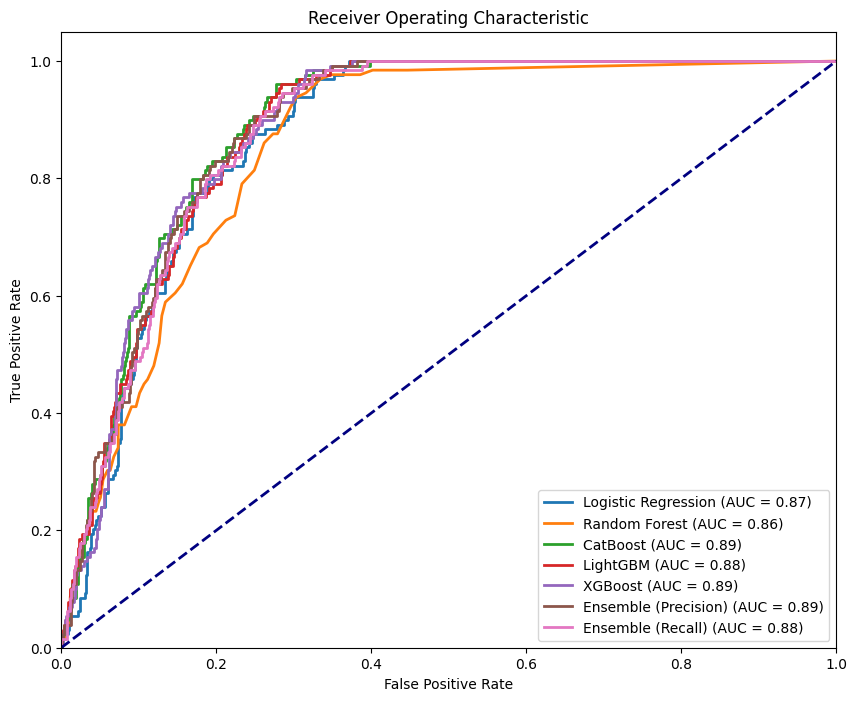

In [34]:
# AUC 값을 저장할 딕셔너리 초기화
auc_values = {}

# ROC 커브와 AUC 추가
plt.figure(figsize=(10, 8))

for index, row in results_df.iterrows():
    if pd.isna(row['y_true']).any() or pd.isna(row['y_scores']).any():
        continue  # y_true 또는 y_scores에 NaN이 있으면 건너뜀
    y_true = row['y_true']
    y_scores = row['y_scores']
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    auc_values[row['Model']] = roc_auc
    plt.plot(fpr, tpr, lw=2, label=f"{row['Model']} (AUC = {roc_auc:.2f})")

# AUC 값을 results_df에 추가
results_df['AUC'] = results_df['Model'].map(auc_values)

# 특정 열(y_true, y_scores) 제외하고 결과 출력
print(f"\nTotal execution time: {execution_time:.2f} seconds")
print("\n=== Model Results ===")
print(results_df.drop(columns=['y_true', 'y_scores']).to_string(index=False))

# 가장 성능이 좋은 모델 찾기 (Accuracy, Precision, Recall, Positive Recall, F1-Score, AUC 기준)
best_model_acc = results_df.loc[results_df['Accuracy'].idxmax()]
best_model_prec = results_df.loc[results_df['Precision'].idxmax()]
best_model_pos_rec = results_df.loc[results_df['Positive Recall'].idxmax()]
best_model_rec = results_df.loc[results_df['Specificity'].idxmax()]
best_model_f1 = results_df.loc[results_df['F1-Score'].idxmax()]
best_model_auc = results_df.loc[results_df['AUC'].idxmax()]

print(f"\nBest performing model (based on Accuracy): {best_model_acc['Model']} with Accuracy {best_model_acc['Accuracy']:.4f}")
print(f"Best performing model (based on Precision): {best_model_prec['Model']} with Precision {best_model_prec['Precision']:.4f}")
print(f"Best performing model (based on Positive Recall): {best_model_pos_rec['Model']} with Positive Recall {best_model_pos_rec['Positive Recall']:.4f}")
print(f"Best performing model (based on F1-Score): {best_model_f1['Model']} with F1-Score {best_model_f1['F1-Score']:.4f}")
print(f"Best performing model (based on AUC): {best_model_auc['Model']} with AUC {best_model_auc['AUC']:.4f}")

# 앙상블 모델들 비교
ens_prec = results_df[results_df['Model'] == 'Ensemble (Precision)'].iloc[0]
ens_rec = results_df[results_df['Model'] == 'Ensemble (Recall)'].iloc[0]

print("\nEnsemble Models Comparison (based on F1-Score):")
print(f"Ensemble (Precision) - F1-Score: {ens_prec['F1-Score']:.4f}")
print(f"Ensemble (Recall) - F1-Score: {ens_rec['F1-Score']:.4f}")

if ens_prec['F1-Score'] > ens_rec['F1-Score']:
    print("Ensemble (Precision) has better overall F1-Score.")
elif ens_prec['F1-Score'] < ens_rec['F1-Score']:
    print("Ensemble (Recall) has better overall F1-Score.")
else:
    print("Both Ensembles have the same overall F1-Score.")

# ROC 커브 그리기
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


In [35]:
# 종료 시간 기록
full_end_time = time.time()
execution_time = full_end_time - full_start_time
execution_time_formatted = str(datetime.timedelta(seconds=int(execution_time)))
print("실행 시간: ", execution_time_formatted)

실행 시간:  0:12:52
